In [1]:
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import seaborn as sns

from evolution.camera.camera_rendering import render_geometry_with_camera
from evolution.strategies import DistanceMap, DistanceMapWithPunishment
from evolution.camera import ObjGeometry

from utils.figure_utils import save_figure


<hr/>

# Settings and utility functions

In [2]:
plt.style.use(['science','ieee'])
DATA_FOLDER = "../data"
OUTPUT_FOLDER = "../output"

<hr/>

# Figure fitnessmap intensity profile

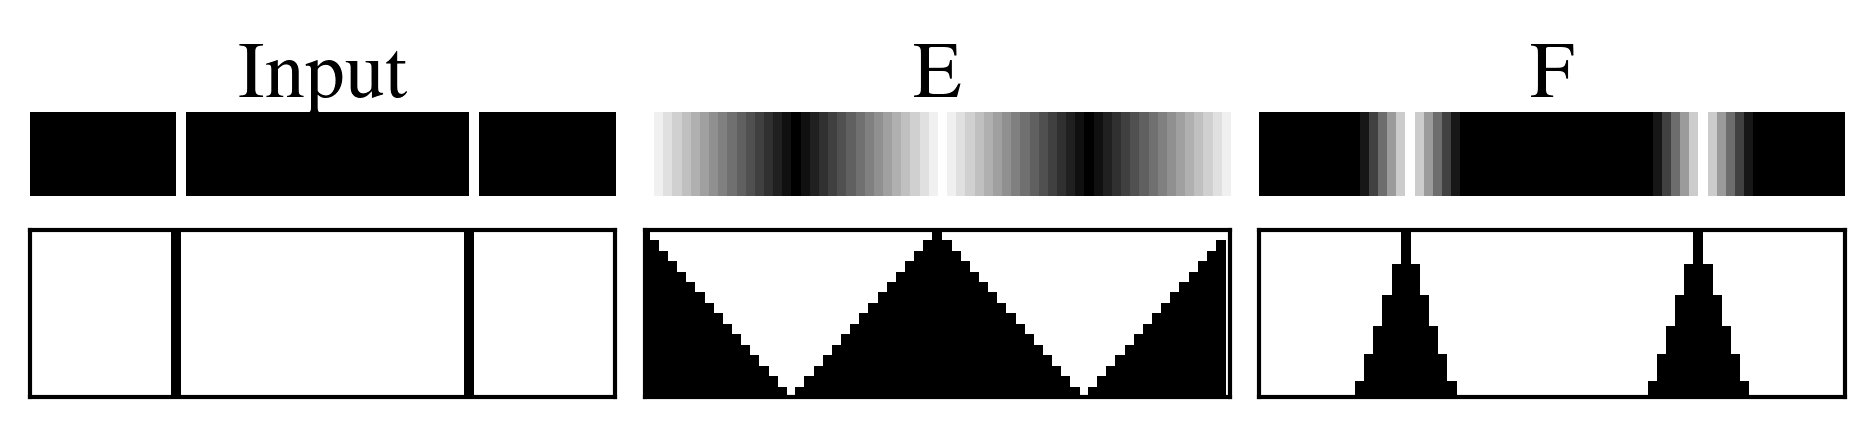

In [3]:
sns.set_context("paper")

w, h = (64,1)
I = np.zeros((h, w), dtype=np.uint8)
cv.line(I, (w//4, 0), (w//4, h), (255), 1)
cv.line(I, (3*w//4, 0), (3*w//4, h), (255), 1)

E = cv.distanceTransform(~I, cv.DIST_L2, 3)
cv.normalize(E, E, 0.0, 1.0, cv.NORM_MINMAX)

F = np.log1p(E) / 0.3
F[F > 1.0] = 1.0
F = 1-F
def show_image(axes, col, title, image):
    h, w = image.shape[:2]
    axes[0, col].imshow(image, cmap="gray", interpolation="nearest", aspect="auto") #, interpolation="nearest", aspect="auto"
    axes[0, col].axis("off")
    axes[1, col].set_title(title, pad=16)
    axes[1, col].stem(image[h//2, :], linefmt="k-", markerfmt="k ", basefmt=" ")
    axes[1, col].set_xticks([])
    axes[1, col].set_xlim([0, w])
    axes[1, col].set_yticks([])
    axes[1, col].set_ylim(0, 1)

    for axis in ['top','bottom','left','right']:
        axes[1, col].spines[axis].set_linewidth(0.5)

PAPER_SIZE = (3.50,1.1)
DEBUG_SIZE = (16, 9)
FIGURE_SIZE = PAPER_SIZE
figure, axs = plt.subplots(2, 3, figsize=FIGURE_SIZE, sharey=True)
figure.tight_layout()
figure.subplots_adjust(hspace=0.2, wspace=0.05)

show_image(axs, 0, "Input", I / 255.)
show_image(axs, 1, "E", E)
show_image(axs, 2, "F", F)

_ = save_figure(figure, f"{OUTPUT_FOLDER}/fitness_intensity.eps")

<hr/>

# Figure fitnessmap comparison

In [4]:
def squash_camera(image_shape: tuple[int, int]):
    fuv = max(image_shape) - 100
    h, w = image_shape

    cu, cv = w // 2, h // 2
    tx, ty, tz = 0.0, 2.35, 8.4
    rx, ry, rz = 0.29, 0.0, 0.0
    A = np.array([fuv, 0, cu, 0, fuv, cv, 0, 0, 1], dtype=np.float32).reshape((3, 3))
    t = np.array([tx, ty, tz], dtype=np.float32)
    r = np.array([rx, ry, rz], dtype=np.float32)
    d = np.zeros(5, dtype=np.float32)
    return A, t, r, d

In [5]:
image_shape = (600, 800)
geometry_file = f"{DATA_FOLDER}/squash/geometries/full_squash_court.obj"
geometry = ObjGeometry(geometry_file)

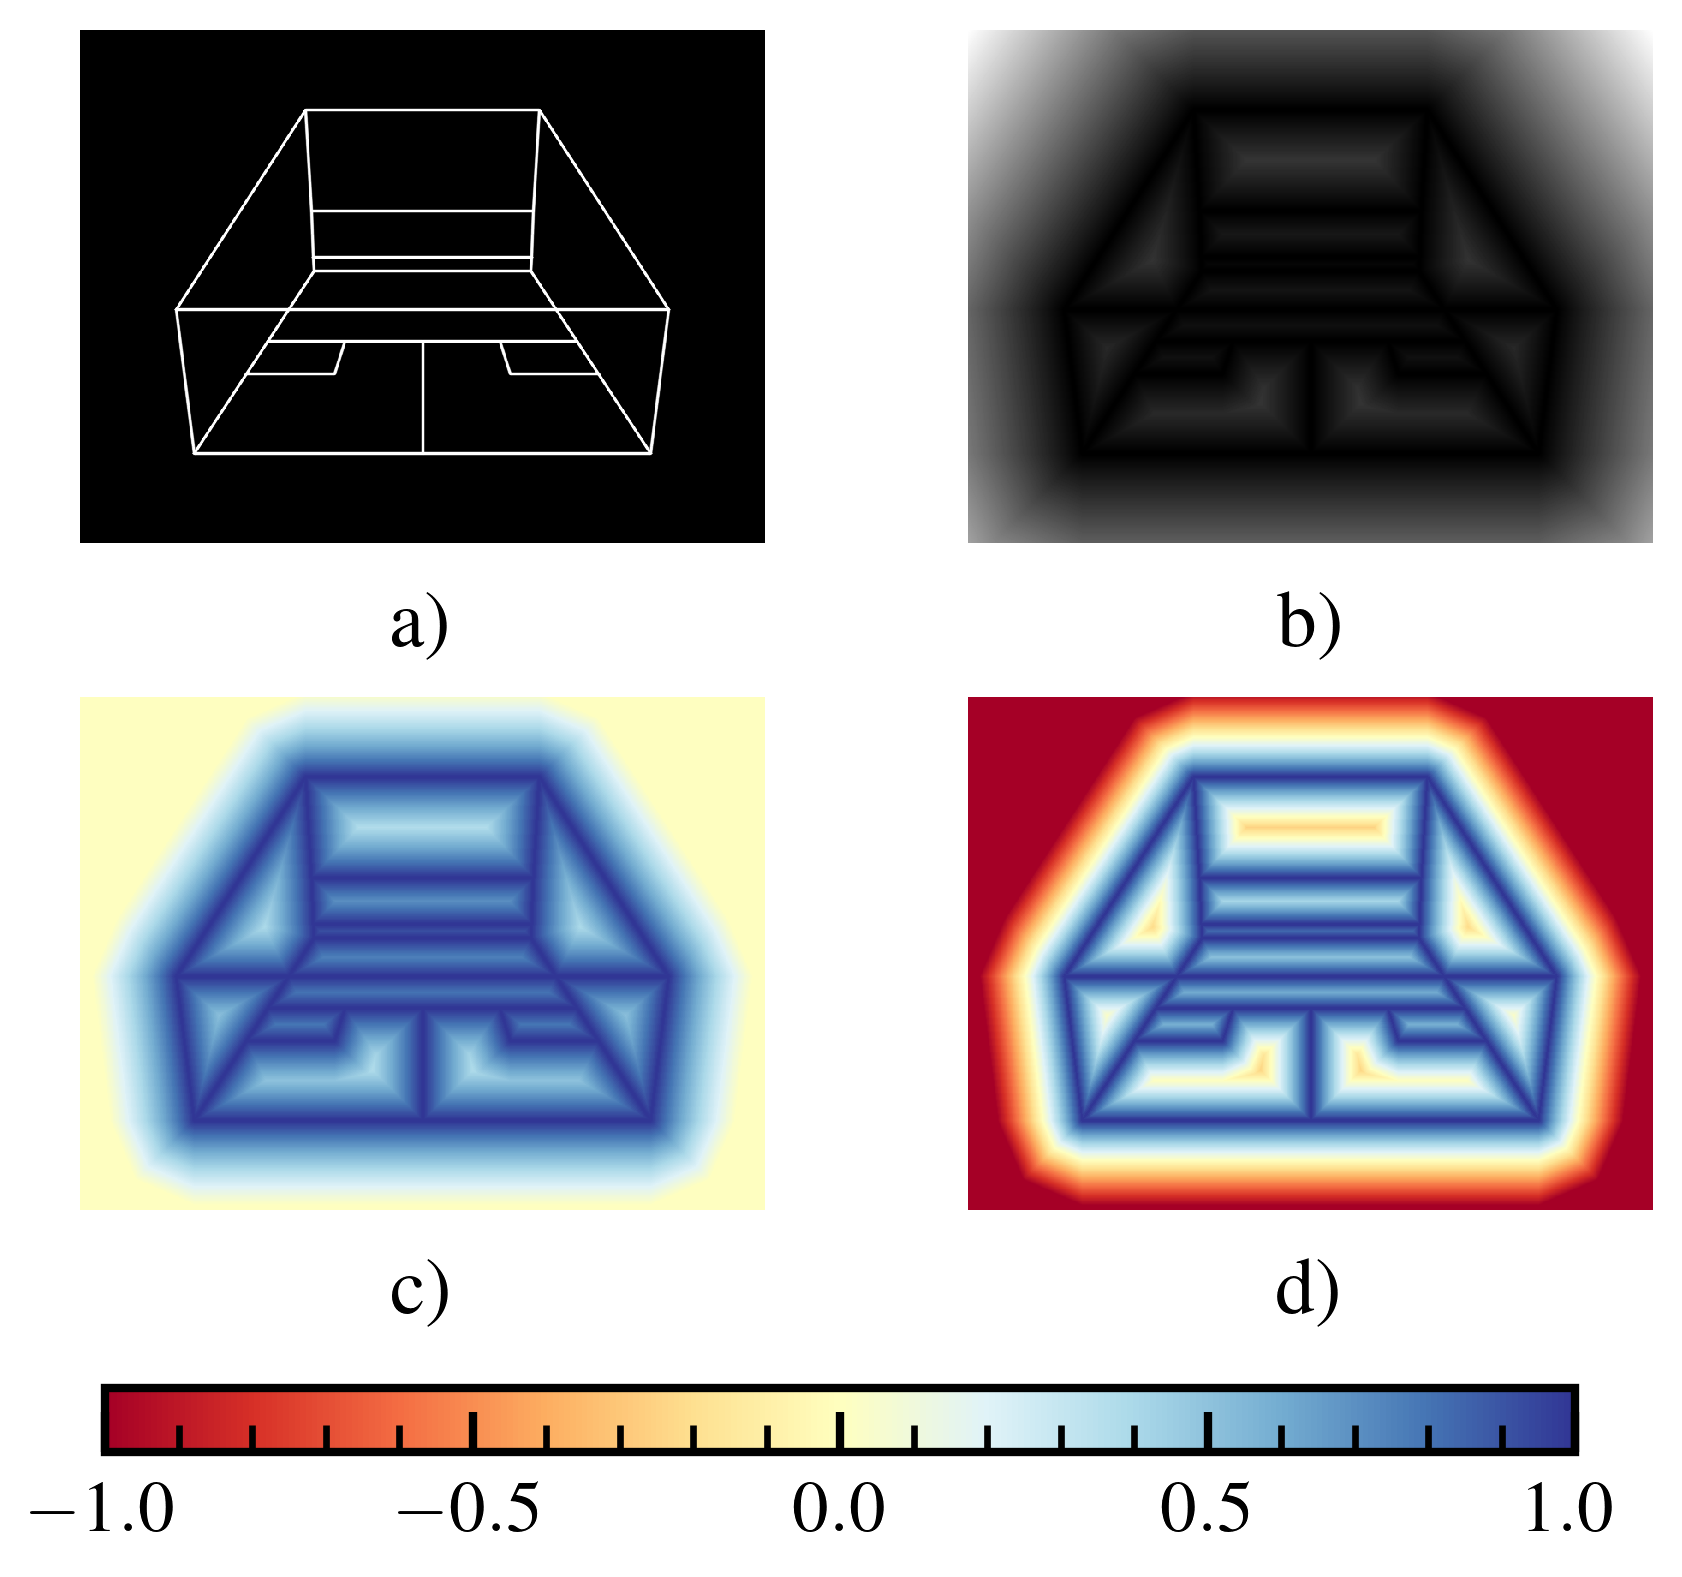

In [6]:
E = np.zeros(image_shape, dtype=np.uint8)

A, t, r, d = squash_camera(image_shape)
render_geometry_with_camera(E, geometry, A, t, r, d, (255,), 2, line_type=cv.LINE_AA)


distance_type = DistanceMap.DistanceType.L2
log_div = 0.3

strategy0 = DistanceMap(distance_type, log_div)
strategy1 = DistanceMapWithPunishment(distance_type, log_div)

D = cv.distanceTransform(~E, distance_type, maskSize=3)
D = cv.normalize(D, D, 0.0, 1.0, cv.NORM_MINMAX)

F0 = strategy0.create_fitness(E)
F1 = strategy1.create_fitness(E)

scl = 1
figure = plt.figure(figsize=(3.50*scl,2.695*scl)) #
grid = gridspec.GridSpec(ncols=2, nrows=2, hspace=0.3, figure=figure)
ax00 = figure.add_subplot(grid[0, 0])
ax01 = figure.add_subplot(grid[0, 1])
ax10 = figure.add_subplot(grid[1, 0])
ax11 = figure.add_subplot(grid[1, 1])

ax00.imshow(E, interpolation="none", cmap="gray")
ax01.imshow(D, interpolation="none", cmap="gray")
ax10.imshow(F0, interpolation="none", cmap='RdYlBu', vmin=-1, vmax=1)
im = ax11.imshow(F1, interpolation="none", cmap='RdYlBu', vmin=-1, vmax=1)

figure.subplots_adjust(bottom=0.15)
cbar_ax = figure.add_axes([0.15, 0, 0.7, 0.04])
figure.colorbar(im, cax=cbar_ax, orientation="horizontal")

ax00.set_title("a)", y=-0.3)
ax01.set_title("b)", y=-0.3)
ax10.set_title("c)", y=-0.3)
ax11.set_title("d)", y=-0.3)

_ = [a.axis("off") for a in (ax00, ax01, ax10, ax11)]

_ = save_figure(figure, f"{OUTPUT_FOLDER}/fitnessmap_comparison.eps")

Comparison of two different fitness maps.

    a) shows the projection of a standard squash court using a camera.
    b) shows the distance transform of a) using a Moore neighborhood together with the Euclidean $L_2$-Norm.
    c) shows the first distance map obtained from b), containing only positive values.
    d) shows the second distance map, additionally containing negative values to model a punishment mechanism.